# Quantum Alternating Operator Ansatz for Graph Coloring Problem with Qiskit and Quri-Parts
In this tutorial, we would like to explain the functionality while solving the Graph Coloring Problem using the Quantum Approximate Optimization Algorithm and the Quantum Alternating Operator Ansatz. This time, we are going to conduct simulations using qiskit and quri-parts.

In [1]:
import networkx as nx
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import qamomile.core as qm

First, we will implement the mathematical model of the graph coloring problem using JijModeling.

In [2]:
def graph_coloring_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring")
    # set one-hot constraint that each vertex has only one color

    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # set objective function: minimize edges whose vertices connected by edges are the same color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

problem = graph_coloring_problem()
problem

Next, we will create an instance of the problem.

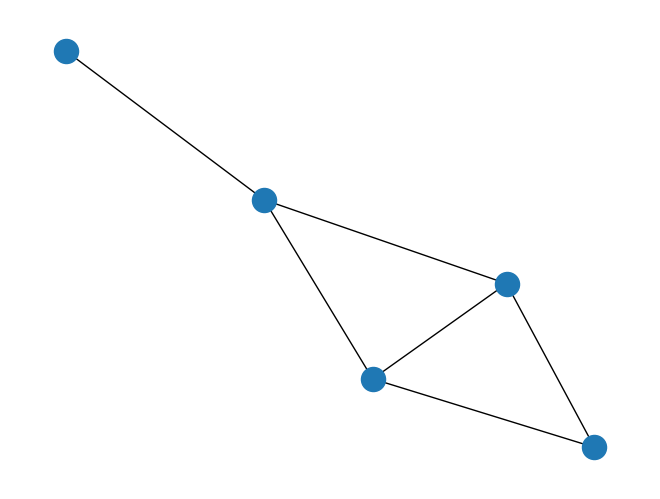

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
nx.draw(G)

In [4]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

# Quantum Approximate Optimazation Algorithm (QAOA)
The Quantum Approximate Optimization Algorithm (QAOA) is one of the quantum optimization algorithms that use a variational quantum circuit. For a detailed explanation, please refer to paper [1], but here we will only give a rough overview.
In QAOA, a variational quantum circuit is constructed by applying the Ising Hamiltonian $H_P = \sum_{ij}J_{ij}Z_iZ_j$ and the $X$-mixer Hamiltonian $H_M = \sum_iX_i$ in the following way:
If we start with an initial state $\ket{\psi_0}$, then

$$
\ket{\psi(\beta,\gamma)} = e^{-\beta_pH_M}e^{-\gamma_pH_P}\cdots e^{-\beta_1H_M}e^{-\gamma_1H_P}\ket{\psi_0}
$$

can be written. Here, $\beta_k,\gamma_k$ are the parameters to be optimized, and since the operation $e^{-\beta_kH_M}e^{-\gamma_kH_P}$ is repeated $p$ times, there are a total of $2p$ parameters. In the standard QAOA, the total number of parameters is independent of the number of qubits and depends only on the number of repetitions.

Optimization of $\beta_k,\gamma_k$ is performed by repeating the following steps 1 and 2:

1. Compute the expectation value $\bra{\psi(\beta,\gamma)}H_P\ket{\psi(\beta,\gamma)}$ on a quantum device.
2. Update the parameters on a classical computer to minimize the expectation value.

By repeating this calculation of the expectation value on the quantum computer and optimization of parameters on the classical computer, we obtain the minimum energy $\langle H_P \rangle$ and the corresponding final state. If we consider QAOA as a mathematical optimization algorithm, this minimum energy corresponds to the minimum objective function value, and the final state becomes the optimal solution.

## Implementing QAOA using Qamomile
Now, let's try solving the Graph Coloring Problem using QAOA.
To execute QAOA, it's necessary to convert the mathematical model into an Ising Hamiltonian, and then create a variational quantum circuit and Hamiltonian using a quantum computing library. However, since Qamomile supports QAOA, it allows for relatively easy execution.

First, using JijModeling-Transpiler, we create a CompiledInstance from JijModeling's mathematical model and instance data.

In [5]:
compiled_instance = jmt.compile_model(problem, instance_data)

Next, we create a QAOAConverter. By setting the weight for the constraints on this Converter, we can create the Hamiltonian.

In [6]:
qaoa_converter = qm.qaoa.QAOAConverter(compiled_instance)
qaoa_converter.ising_encode(multipliers={"one-color": 1})
qaoa_circuit = qaoa_converter.get_qaoa_ansatz(p=1)
qaoa_cost = qaoa_converter.get_cost_hamiltonian()

## Run QAOA using Qiskit

Now that we have the variational quantum circuit and Hamiltonian ready, let's actually execute QAOA using Qiskit.  
Transpile the qamomile's circuit to the qiskit's circuit and run the simulation.

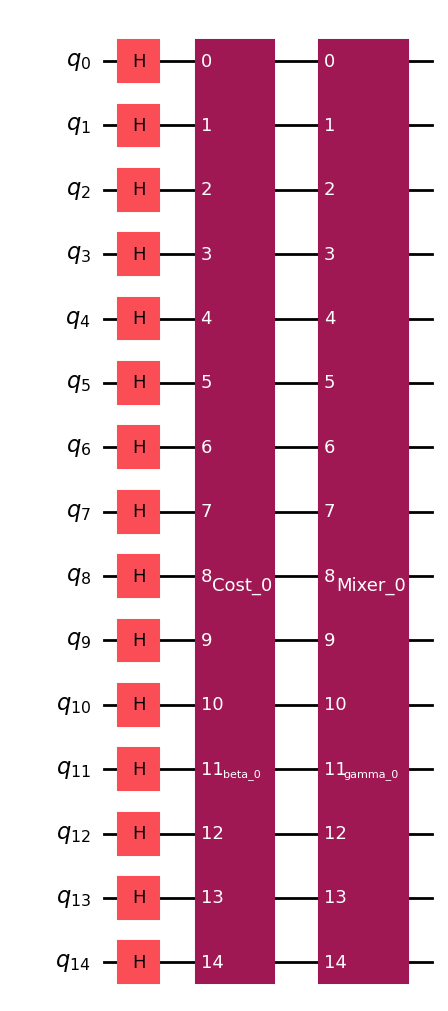

In [7]:
from qamomile.qiskit import QiskitTranspiler
import qiskit.primitives as qk_pr

qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(qaoa_circuit)
qk_cost = qk_transpiler.transpile_hamiltonian(qaoa_cost)

qk_circuit.draw(output="mpl")

In [8]:
import scipy.optimize as opt

# Variational Step
estimator = qk_pr.StatevectorEstimator()

cost_history = []
def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data['evs']
    cost_history.append(cost)
    return cost

result = opt.minimize(estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 100})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.646036573651008
       x: [ 3.551e-01 -4.544e-01]
    nfev: 42
   maxcv: 0.0

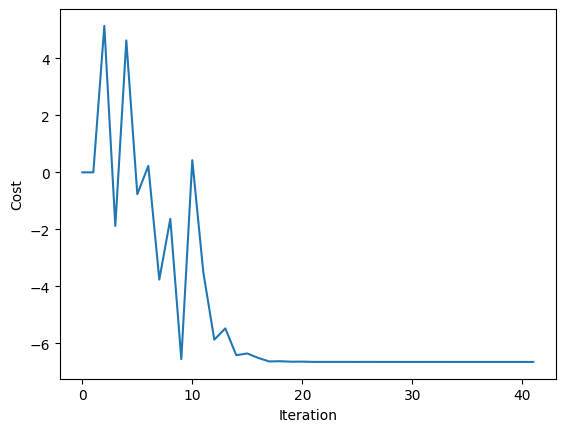

In [9]:
import matplotlib.pyplot as plt

plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

# Quantum Alternating Operator Ansatz
Next, let's try solving the graph coloring problem using the Quantum Alternating Operator Ansatz. The Quantum Alternating Operator Ansatz[2] is a modification of QAOA, where the mixer is changed from an $X$-mixer to a mixer tailored to the problem, ensuring that only solutions satisfying the constraints are searched for. For more detailed information, please refer to the original paper. Here, we will look at how to implement it in JTQ.

For the Graph Coloring problem, there is a one-hot constraint:

$$
\sum_k x_{v,k} = 1\quad \forall v
$$

However, turning this into an $XY$-mixer is the Quantum Alternating Operator Ansatz approach to the Graph Coloring problem.

In [10]:
gamma = qm.circuit.Parameter("gamma")
qaoa_converter.ising_encode(multipliers={"one-color": 0.0})  # Delete one-color penalty.
qaoa_cost_circuit = qaoa_converter.get_cost_ansatz(gamma)    # Get exp(-i beta H_C) circuit without mixer circuit.

Next, we will create an $XY$-mixer. The $XY$-mixer can be written as

$$
XY_{ij} = \frac{1}{2}\left(X_iX_j + Y_iY_j \right).
$$

This is an operator that swaps the bits 1 and 0 in bit $i,j$. Therefore, it can transform a bit string $100$, which satisfies the one-hot constraint, into another bit string $010$, which also satisfies the one-hot constraint.

Here, the only part under the one-hot constraint is related to color, so in terms of the mathematical model, we need to transform the bits between $x_{v0}$ and $x_{v1}$.
On the other hand, as these variables are usually embedded in qubits, it is necessary to remember which bit corresponds to which variable when constructing the algorithm and handle them appropriately.
In JTQ, the correspondence of variables is contained in var_map inside CompiledInstance.
```python
var_map['variable_name'][indices]
```
You can check which qubit corresponds to a variable in the mathematical model in this way.
Let's use this to create an $XY$-mixer.

What we want here is the transformation between $x_{v,k}$ and $x_{v,k+1}$, so we can obtain the index of the corresponding qubit by accessing compiled_instance.var_map.var_map["x"][(i,k)]."

In [11]:
def create_xy_mixer(
    beta: qm.circuit.Parameter,
    num_nodes: int,
    num_color: int,
    compiled_instance: jmt.CompiledInstance,
):
    n = num_color * num_nodes
    qc = qm.circuit.QuantumCircuit(n, name="xy-mixer")
    var_map = compiled_instance.var_map.var_map["x"]
    # even
    for i in range(num_nodes):
        for k in range(0, num_color - 1, 2):
            qc.rxx(beta, var_map[(i, k)], var_map[(i, k + 1)])
            qc.ryy(beta, var_map[(i, k)], var_map[(i, k + 1)])

    # odd
    for i in range(num_nodes):
        for k in range(1, num_color - 1, 2):
            qc.rxx(beta, var_map[(i, k)], var_map[(i, k + 1)])
            qc.ryy(beta, var_map[(i, k)], var_map[(i, k + 1)])

    # ini-last
    if num_color % 2 == 1:
        for i in range(num_nodes):
            qc.rxx(beta, var_map[(i, 0)], var_map[(i, num_color - 1)])
            qc.ryy(beta, var_map[(i, 0)], var_map[(i, num_color - 1)])
    return qc

In [12]:
def create_initial_state(
    compiled_instance: jmt.CompiledInstance, num_nodes: int, num_color: int
):
    n = num_color * num_nodes
    qc = qm.circuit.QuantumCircuit(n)
    var_map = compiled_instance.var_map.var_map["x"]
    for i in range(num_nodes):
        qc.x(var_map[(i, 0)])  # set all nodes to color 0
    return qc

Now that the Ansatz has been created, we would like to run the Quantum Alternating Operator Ansatz.

In [13]:
initial_circuit = create_initial_state(compiled_instance, num_nodes, color_num)
beta = qm.circuit.Parameter("beta")
mixer_circuit = create_xy_mixer(beta, num_nodes, color_num, compiled_instance)
initial_circuit.append(qaoa_cost_circuit)
initial_circuit.append(mixer_circuit)

alternating_ansatz = initial_circuit

## Run Quantum Alternating Operator Ansatz using Qiskit

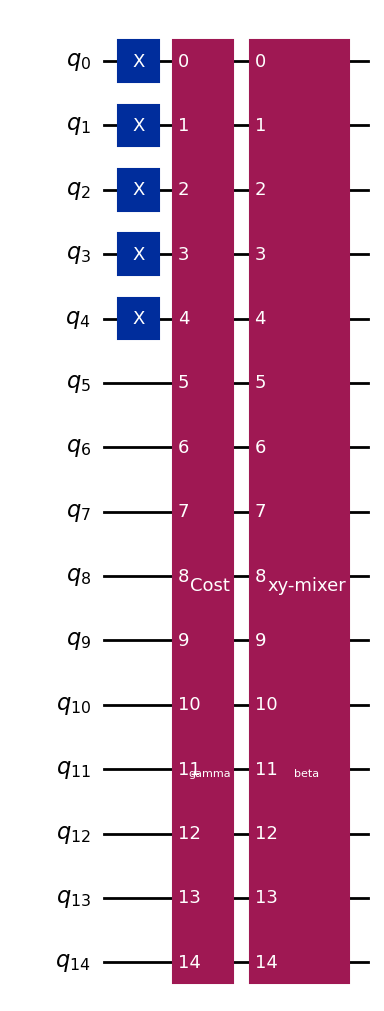

In [14]:
qk_transpiler = QiskitTranspiler()
qk_circuit = qk_transpiler.transpile_circuit(alternating_ansatz)
qk_circuit.draw(output="mpl")

In [15]:
# Variational Step
estimator = qk_pr.StatevectorEstimator()

cost_history = []

def estinamate_cost(params):
    job = estimator.run([(qk_circuit, qk_cost, params)])
    job_result = job.result()
    cost = job_result[0].data["evs"]
    cost_history.append(cost)
    return cost


result = opt.minimize(
    estinamate_cost, [0, 0], method="COBYLA", options={"maxiter": 100}
)
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.43749997649938
       x: [ 7.855e-01 -1.425e-01]
    nfev: 31
   maxcv: 0.0

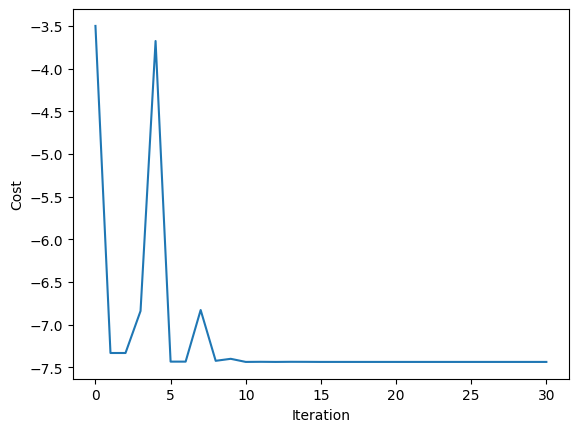

In [16]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [17]:
sampler = qk_pr.StatevectorSampler()
qk_circuit.measure_all()
plt.show()
job = sampler.run([(qk_circuit, result.x)])
job_result = job.result()

In [18]:
sampleset = qaoa_converter.decode(qk_transpiler, job_result[0].data['meas'])

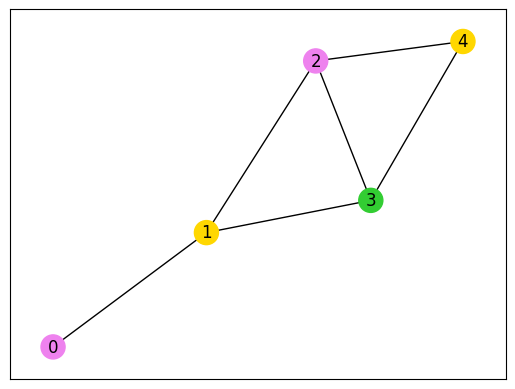

In [19]:
import numpy as np
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.experimental.SampleSet):
    # extract feasible solution
    feasibles = sampleset.feasibles()
    if len(feasibles) == 0:
        print("No feasible solution found ...")
    else:
        lowest_sample = sampleset.lowest()[0]

        # get indices of x = 1
        indices = lowest_sample.var_values["x"].values.keys()
        # get vertices and colors
        # initialize vertex color list
        node_colors = [-1] * graph.number_of_nodes()
        # set color list for visualization
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # set vertex color list
        for i, j in indices:
            node_colors[i] = colorlist[j]
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

plot_graph_coloring(G, sampleset)

## Alternating Ansatz with Quri-Parts

In [20]:
# !pip install quri-parts-algo

In [21]:
from qamomile.quri_parts import QuriPartsTranspiler

In [22]:
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

qp_transpiler = QuriPartsTranspiler()
qp_alternating_circuit = qp_transpiler.transpile_circuit(alternating_ansatz)
qp_cost = qp_transpiler.transpile_hamiltonian(qaoa_cost)

In [23]:
draw_circuit(qp_alternating_circuit)

   ___     ___     ___            ___             ___                           
  | X |   |PRZ|   |PPR|          |PPR|           |PPR|                          
--|0  |---|5  |---|20 |----------|38 |-----------|39 |--------------------------
  |___|   |___|   |   |          |_ _|           |_ _|                          
   ___     ___    |   |    ___    | |      ___    | |                     ___   
  | X |   |PRZ|   |   |   |PPR|   | |     |PPR|   | |                    |PPR|  
--|1  |---|6  |---|   |---|21 |---| |-----|22 |---| |--------------------|41 |--
  |___|   |___|   |___|   |   |   | |     |_ _|   | |                    |_ _|  
   ___     ___            |   |   | |      | |    | |      ___            | |   
  | X |   |PRZ|           |   |   | |      | |    | |     |PPR|           | |   
--|2  |---|7  |-----------|   |---| |------| |----| |-----|23 |-----------| |---
  |___|   |___|           |___|   | |      | |    | |     |   |           | |   
   ___     ___              

In [24]:
from quri_parts.core.state import quantum_state, apply_circuit

cb_state = quantum_state(alternating_ansatz.num_qubits, bits=0)
parametric_state = apply_circuit(qp_alternating_circuit, cb_state)

In [25]:
from typing import Sequence
from quri_parts.qulacs.estimator import create_qulacs_vector_parametric_estimator

estimator = create_qulacs_vector_parametric_estimator()


cost_history = []
def cost_fn(param_values: Sequence[float]) -> float:
    estimate = estimator(qp_cost, parametric_state, param_values)
    cost = estimate.value.real
    cost_history.append(cost)
    return cost


result = opt.minimize(cost_fn, [0, 0], method="COBYLA", options={"maxiter": 100})
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.826161402531299
       x: [-5.693e-01 -4.550e-01]
    nfev: 36
   maxcv: 0.0

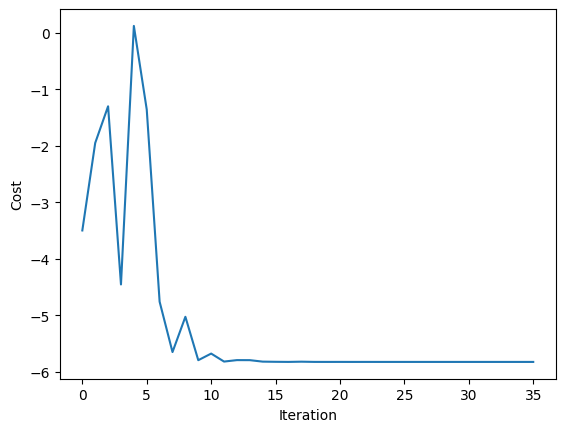

In [26]:
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [27]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler


sampler = create_qulacs_vector_sampler()
bounded_circuit = qp_alternating_circuit.bind_parameters(result.x)
qp_result = sampler(bounded_circuit, 1000)

In [28]:
sampleset = qaoa_converter.decode(qp_transpiler, (qp_result, alternating_ansatz.num_qubits))

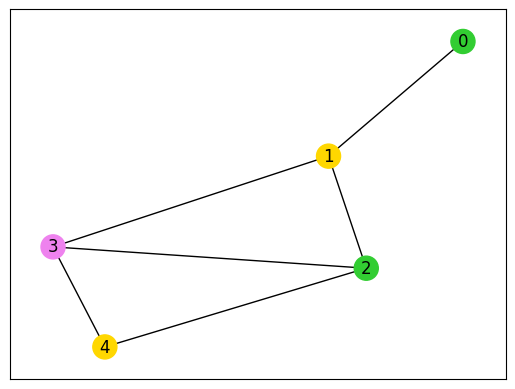

In [29]:
plot_graph_coloring(G, sampleset)